In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [10]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

Recent Date:  2017-08-23
Query Date:  2016-08-23


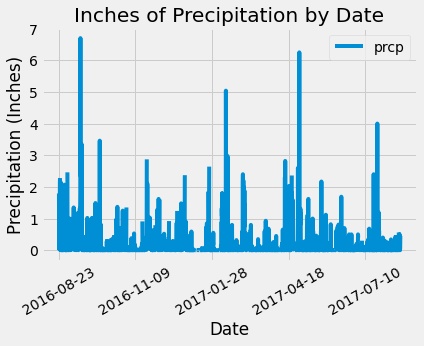

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
last_date = str(session.query(Measurement.date).order_by(Measurement.date.desc()).first())
recent_date = dt.datetime.strptime(last_date, "('%Y-%m-%d',)")
print("Recent Date: ", recent_date.date())
# Calculate the date one year from the last date in data set.
query_date = recent_date.date() - dt.timedelta(days=365)
print("Query Date: ", query_date)
# Perform a query to retrieve the data and precipitation scores
precipitation_scores = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date <= recent_date).\
    filter(Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation = pd.DataFrame(precipitation_scores).set_index('date')

# Sort the dataframe by date
precipitation = precipitation.sort_values(by=['date'])

# Use Pandas Plotting with Matplotlib to plot the data
ax = precipitation.plot(title = 'Inches of Precipitation by Date', rot=30)
ax.set_ylabel('Precipitation (Inches)')
ax.set_xlabel('Date')

#print plot and clear variables
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summ_stats = precipitation['prcp'].agg(['mean', 'median', 'var', 'std', 'sem'])
summ_stats

mean      0.177279
median    0.020000
var       0.212696
std       0.461190
sem       0.010259
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [21]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.station).count()

9

In [36]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [48]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

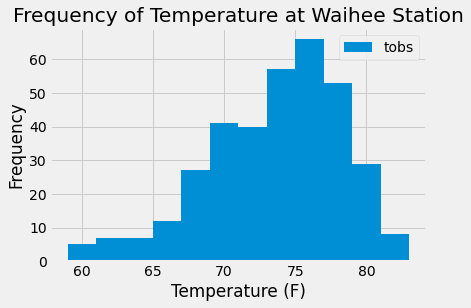

In [47]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temperature = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date <= recent_date).\
    filter(Measurement.date >= query_date).all()

active_temperature = pd.DataFrame(temperature).set_index('date')

ax = active_temperature.plot.hist(bins=12, title = "Frequency of Temperature at Waihee Station")
ax.set_xlabel('Temperature (F)')
plt.show()

# Close session

In [ ]:
# Close Session
session.close()